# Assignment — Graph Contrastive Learning

### Task 1. Augmentation (2 points)

In [ ]:
#!pip install dgl-cu111 -f https://data.dgl.ai/wheels/repo.html -q
!pip install dgl -q

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

import dgl
from dgl.nn import GraphConv
from dgl.dataloading import GraphDataLoader
from dgl.data import DGLDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Subset

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

from IPython.display import clear_output

<img src='https://raw.githubusercontent.com/netspractice/advanced_gnn/main/assignment_contrastive_learning/contrastive_learning.png' width=500>

Source: https://arxiv.org/abs/2103.00111

Contrastive learning aims to learn representations by maximizing feature consistency under differently augmented views, that exploit data- or task-specific augmentations. In a case of graph representation learning, there are some augmentation techniques that can be used to produce graph embeddings for downstream tasks, say classification.

Write a class `GraphAugmentation` with a function `transform` that takes a graph and returns an augmented graph. Types of augmentation:
* `drop_nodes` — randomly drops a share of nodes with a given ratio
* `pert_edges` — randomly perturbs (rewires) a share of edges with a given ratio
* `attr_mask` — randomly masks a share of node attributes with a given ratio and a name in `ndata` collection
* `rw_subgraph` — builds a subgraph based on random walk
* `identical` — the same graph, no augmentation

Augmentations are applied to graphs with self-loops, so keep self-loops during edges perturbation. Parallel edges are allowed after perturbation. A random walk subgraph is constructed by (1) adding a random starting node, (2) adding all its neighbors, (3) adding all neighbors of a random node in the subgraph and repeating the step 3 while number of nodes exceeds the threshold `(1 - ratio)`.

In [ ]:
class GraphAugmentation():
    def __init__(self, type, ratio=0.2, node_feat='attr'):
        self.type = type
        self.ratio = ratio
        self.node_feat = node_feat
    
    def transform(self, g):
        if self.type == 'drop_nodes':
            return self.drop_nodes(g)
        elif self.type == 'pert_edges':
            return self.pert_edges(g)
        elif self.type == 'attr_mask':
            return self.attr_mask(g)
        elif self.type == 'rw_subgraph':
            return self.rw_subgraph(g)
        elif self.type == 'identical':
            return g
    
    def drop_nodes(self, g):
        # YOUR CODE HERE
        aug_g = g.clone()
        n = int(np.ceil(aug_g.num_nodes() * self.ratio))
        aug_g.remove_nodes(np.random.choice(aug_g.nodes(), n, replace=False))
        aug_g = aug_g.remove_self_loop()
        aug_g = aug_g.add_self_loop()
        return aug_g

    def pert_edges(self, g):
        # YOUR CODE HERE
        aug_g = g.clone()
        aug_g = aug_g.remove_self_loop()
        n = int(np.ceil(aug_g.num_edges() * self.ratio))
        aug_g.remove_edges(np.random.choice(aug_g.num_edges(), n, replace=False))
        new_edges = np.array([np.random.choice(aug_g.num_nodes(), 2, replace=False) for _ in range(n)]).T
        aug_g.add_edges(new_edges[0], new_edges[1])
        aug_g = aug_g.add_self_loop()
        return aug_g

    def attr_mask(self, g):
        # YOUR CODE HERE
        aug_g = g.clone()
        feat_shape = aug_g.ndata[self.node_feat].shape[1]
        n = int(np.ceil(feat_shape * self.ratio))
        masked_nodes = np.random.choice(feat_shape, n, replace=False)
        mask = torch.ones(feat_shape)
        mask[masked_nodes] = 0
        mask = mask.repeat(aug_g.num_nodes(), 1)
        aug_g.ndata[self.node_feat] = g.ndata[self.node_feat] * mask
        return aug_g

    def rw_subgraph(self, g):
        # YOUR CODE HERE
        aug_g = g.clone()
        n = int(np.ceil(aug_g.num_nodes() * (1 - self.ratio)))
        subgraph = np.random.choice(aug_g.nodes(), 1)
        while len(subgraph) < n:
            sampled_node = np.random.choice(subgraph)
            subgraph = set(subgraph) | set(g.out_edges(sampled_node)[1])
            subgraph = list(subgraph)
        aug_g = aug_g.subgraph(np.array(subgraph))
        aug_g = aug_g.remove_self_loop()
        aug_g = aug_g.add_self_loop()
        return aug_g

In [ ]:
g = dgl.rand_graph(100, 300)
g = g.remove_self_loop()
g = g.add_self_loop()
g.ndata['attr'] = torch.ones(100, 10)
g

Graph(num_nodes=100, num_edges=399,
      ndata_schemes={'attr': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={})

In [ ]:
ratio = 0.7
aug = GraphAugmentation('drop_nodes', ratio=ratio)
aug_g = aug.transform(g)
assert aug_g.ndata['attr'].shape[1] == g.ndata['attr'].shape[1]
assert aug_g.ndata['attr'].shape[0] < g.ndata['attr'].shape[0]
assert aug_g.ndata['attr'].shape[0] == int(g.number_of_nodes() * (1 - ratio))
G = nx.Graph(aug_g.to_networkx())
assert np.isclose(nx.laplacian_spectrum(G), 0).sum() > 1

In [ ]:
aug = GraphAugmentation('pert_edges', ratio=0.2)
aug_g = aug.transform(g)
assert aug_g.ndata['attr'].shape == g.ndata['attr'].shape
assert aug_g.number_of_edges() == g.number_of_edges()
assert not torch.all(aug_g.adj().to_dense() == g.adj().to_dense())

In [ ]:
aug = GraphAugmentation('attr_mask', ratio=0.2, node_feat='attr')
aug_g = aug.transform(g)
assert aug_g.ndata['attr'].shape == (100, 10)
mask = (aug_g.ndata['attr'][0, :] == 0).repeat(100, 1)
assert torch.all(aug_g.ndata['attr'][mask] == 0)
assert torch.all(aug_g.ndata['attr'][~mask] == 1)

In [ ]:
aug = GraphAugmentation('rw_subgraph', ratio=0.7)
aug_g = aug.transform(g)
assert aug_g.ndata['attr'].shape[1] == g.ndata['attr'].shape[1]
assert aug_g.ndata['attr'].shape[0] < g.ndata['attr'].shape[0]
G = nx.Graph(aug_g.to_networkx())
assert np.isclose(nx.laplacian_spectrum(G), 0).sum() == 1

### Task 2. Contrastive dataset (2 points)

We will fed augmented graphs into encoder during training to obtain graph embeddings. Let us prepare a graph contrastive dataset class so that each element in the dataset will represent augmented graphs and a label.

Write a class `ContrastiveDataset` with a function `__getitem__` that takes a graph's index and returns a tuple:
* an initial graph
* a graph after the first augmentation
* a graph after the second augmentation
* a label

In [ ]:
class ContrastiveDataset(DGLDataset):
    def __init__(self, filename, augmentations):
        self.filename = filename
        self.graphs = None
        self.labels = None
        self.augmentations = augmentations
        assert len(self.augmentations) == 2
        super().__init__(name=filename)

    def process(self):
        graphs, graph_data = dgl.load_graphs(self.filename)
        self.graphs = graphs
        self.labels = graph_data['labels']

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        # YOUR CODE HERE
        g = self.graphs[idx]
        return g, self.augmentations[0].transform(g), self.augmentations[1].transform(g), self.labels[idx]

PROTEINS is a dataset with 1113 proteins where nodes are secondary structure elements and there is an edge between two nodes if they are neighbors in the amino-acid sequence or in 3D space. It has 3 discrete labels, representing helix, sheet or turn. Proteins are divided into two classes: enzymes and non-enzymes. Source: https://arxiv.org/abs/2007.08663.

Let us create a dataset with dropping nodes and masking attributes augmentations.

In [ ]:
url = 'https://github.com/netspractice/advanced_gnn/raw/main/assignment_contrastive_learning/proteins.bin'
open('proteins.bin', 'wb').write(requests.get(url).content);

augmentations = []
augmentations.append(GraphAugmentation('drop_nodes', ratio=0.1))
augmentations.append(GraphAugmentation('attr_mask', ratio=0.4, node_feat='attr'))
dataset = ContrastiveDataset(filename='proteins.bin', augmentations=augmentations)
N = len(dataset)
N

1113

In [ ]:
g, aug_g1, aug_g2, label = dataset[0]
assert g.ndata['attr'].shape == (42, 3)
assert aug_g1.ndata['attr'].shape == (37, 3)
assert g.ndata['attr'].sum() <= 42

Since we perform the random walk subgraph augmentation, we want to make sure all initial graphs are connected.

Write a function `connected_subset` that takes an initial dataset and returns a `torch.utils.data.dataset.Subset` with connected graphs only.

In [ ]:
def connected_subset(dataset):
    # YOUR CODE HERE
    return Subset(
        dataset=dataset,
        indices=[
            idx for idx, g in enumerate(dataset.graphs)
            if nx.number_connected_components(nx.Graph(dgl.to_networkx(g))) == 1
        ])

In [ ]:
c_dataset = connected_subset(dataset)
N = len(c_dataset)
assert N == 1067

Let us look at some graphs in the dataset.

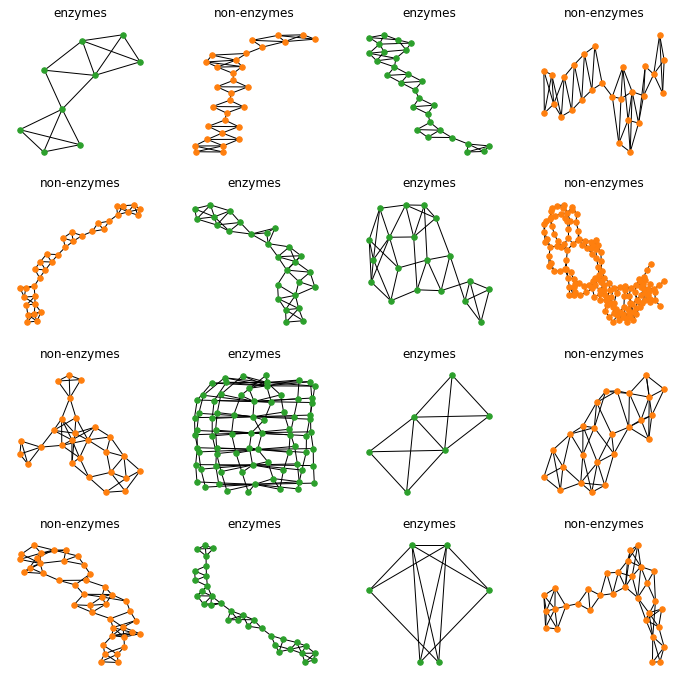

In [ ]:
colors = ['tab:orange', 'tab:green']
plt.figure(figsize=(12, 12))
np.random.seed(0)
for i in range(16):
    plt.subplot(4, 4, i+1)
    g, _, _, l = c_dataset[np.random.randint(N)]
    g = nx.Graph(g.to_networkx())
    g.remove_edges_from(nx.selfloop_edges(g))
    nx.draw_kamada_kawai(g, node_size=30, node_color=colors[l])
    plt.title('enzymes' if l == 1 else 'non-enzymes')

### Task 3. GCN Encoder (1 point)

Let an encoder be the two-layers GCN (`GraphConv` in `dgl`) with mean graph pooling and two-layers MLP projection head. All layers except of input and output ones have `hidden_dim` dimensionality. Apply ReLU as an activation function.

Write a class `GCNEncoder` with a function `forward` that takes a batch of graphs, node attrubute name in `ndata` collection and returns graph embeddings.

In [ ]:
class GCNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # YOUR CODE HERE
        self.conv1 = GraphConv(input_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.pooling = dgl.nn.AvgPooling()
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.activation = nn.ReLU()

    def forward(self, g, node_feat):
        # YOUR CODE HERE
        h = g.ndata[node_feat]
        h = self.activation(self.conv1(g, h))
        h = self.activation(self.conv2(g, h))
        h = self.activation(self.pooling(g, h))
        h = self.activation(self.fc1(h))
        h = self.fc2(h)
        return h

In [ ]:
batch = []
for _ in range(2):
    g = dgl.rand_graph(100, 300)
    g = g.remove_self_loop()
    g = g.add_self_loop()
    g.ndata['attr'] = torch.ones(100, 10)
    batch.append(g)
batch = dgl.batch(batch)

encoder = GCNEncoder(input_dim=10, hidden_dim=32, output_dim=16)
emb = encoder(batch, 'attr')
assert emb.shape == (2, 16)

### Task 4. Classification on untrained encoder (1 point)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

Let us check the logistic regression model on the untrained encoder output.

Write a function `train_test_split` that splits the dataset into train and test sets by given one-hot encoded vectors `train_idx` and `test_idx`.

In [ ]:
def train_test_split(c_dataset, train_idx, test_idx):
    # YOUR CODE HERE
    graph_train, graph_test, y_train, y_test = [], [], [], []
    for i, (g, _, _, label) in enumerate(c_dataset):
        if i in train_idx:
            graph_train.append(g)
            y_train.append(label)
        if i in test_idx:
            graph_test.append(g)
            y_test.append(label)

    graph_train, graph_test = dgl.batch(graph_train), dgl.batch(graph_test)
    y_train, y_test = torch.tensor(np.array(y_train)), torch.tensor(np.array(y_test))
    return graph_train, graph_test, y_train, y_test

In [ ]:
np.random.seed(0)
ratio = [0.9, 0.1] # train test ratio
split_idx = ['train'] * int(ratio[0] * N) \
    + ['test'] * int(ratio[1] * N)
split_idx = np.random.permutation(split_idx)
train_idx = np.where(split_idx == 'train')[0]
test_idx = np.where(split_idx == 'test')[0]

graph_train, graph_test, y_train, y_test = train_test_split(
    c_dataset, train_idx, test_idx)
assert graph_train.ndata['attr'].shape == (36363, 3)
assert graph_test.ndata['attr'].shape == (3740, 3)
assert y_train.shape == (960, )
assert y_test.shape == (106, )

Let us check the classification score and look at tSNE visualization.

In [ ]:
encoder = GCNEncoder(input_dim=3, hidden_dim=32, output_dim=16)
encoder.to(device)

GCNEncoder(
  (conv1): GraphConv(in=3, out=32, normalization=both, activation=None)
  (conv2): GraphConv(in=32, out=32, normalization=both, activation=None)
  (pooling): AvgPooling()
  (fc1): Linear(in_features=32, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (activation): ReLU()
)

In [ ]:
def classification_score(graph_train, graph_test, y_train, y_test, encoder, show=True):
    
    with torch.no_grad():
        X_train = encoder(graph_train, 'attr').cpu()
        X_test = encoder(graph_test, 'attr').cpu()
    
    clf = LogisticRegression()
    clf.fit(X_train, y_train.cpu())
    score = clf.score(X_test, y_test.cpu())
    
    if show:
        plt.figure(figsize=(10, 6))
        cmap = plt.cm.Set1_r
        dec = TSNE(n_components=2)
        xy_emb = dec.fit_transform(X_train)
        plt.scatter(xy_emb[:, 0], xy_emb[:, 1], c=y_train.cpu(), cmap=cmap, s=5)
        plt.title('tSNE visualization')
        plt.show()
        print('Accuracy: {:.4f}'.format(score))
    
    return score

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


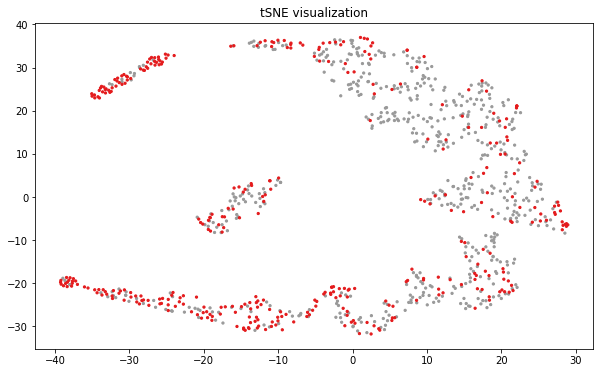

Accuracy: 0.5660


In [ ]:
score = classification_score(graph_train, graph_test, y_train, y_test, encoder)

### Task 5. Contrastive loss (2 points)

In graph contrastive learning, pre-training is performed through maximizing the agreement between two augmented views of the same graph via a contrastive loss in the latent space. Contrastive loss function is defined to enforce maximizing the consistency between positive pairs $z_i$, $z_j$ (the same graph under different augmentations) compared with negative pairs. Here we utilize the NT-Xent Loss that is defined for $n$-th graph in a batch of $N$ graphs as follows:

$$l_{n}=-\log \frac{\exp \left(\text{sim}(z_{n, i}, z_{n, j}) / \tau \right)}{\sum_{n'=1, n' \neq n}^{N} \exp \left( \text{sim}(z_{n, i}, z_{n', j}) / \tau \right)}$$

where $\text{sim}$ is cosine similarity $\text{sim}(z_i, z_j) = z_i^\top z_j / (\| z_i \| \cdot \| z_j \|)$ and $\tau$ is a temperature parameter.

Source: https://arxiv.org/pdf/2010.13902.pdf

Write a function `ntxent` that takes a batch of agmented graph embeddings `x1` and a batch of agmented graph embeddings `x2` and returns mean loss value among all graphs $L = \frac{1}{N}\sum_{n=1}^N l_n$.

_Hint: it is possible to use matrix operations only, with no loops._

In [ ]:
def ntxent(x1, x2, tau=0.1):
    # YOUR CODE HERE
    n = x1.shape[0]
    norm1 = torch.linalg.norm(x1, axis=1).unsqueeze(1).repeat(1, n)
    norm2 = torch.linalg.norm(x2, axis=1).repeat(n, 1)
    sim = x1 @ x2.T / norm1 / norm2 / tau
    l_n = -torch.diag(sim) + torch.logsumexp(sim - torch.diag(torch.full((n, ), torch.inf)), dim=1)
    return torch.mean(l_n)

In [ ]:
x1 = torch.tensor([[1., 0.], [0., 1.]])
x2 = torch.tensor([[1., 0.], [0., 1.]])
assert ntxent(x1, x2) == -10

x1 = torch.tensor([[1., 0.], [0., 1.]])
x2 = torch.tensor([[0., 1.], [1., 0.]])
assert ntxent(x1, x2) == 10

torch.manual_seed(0)
x1 = torch.randn(128, 16)
x2 = torch.randn(128, 16)
assert round(ntxent(x1, x2).item(), 4) == 7.191

### Task 6. Training loop (1 point)

Let us train encoder under contrastive loss and then check classification score.

In [ ]:
loader = GraphDataLoader(
    c_dataset,
    batch_size=64,
    drop_last=False,
    shuffle=True)

In [ ]:
encoder = GCNEncoder(input_dim=3, hidden_dim=32, output_dim=16)
encoder.to(device)
opt = Adam(encoder.parameters(), lr=0.005)

Write a function `train` that takes augmented batches, makes optimization step and returns a loss value.

In [ ]:
def train(encoder, aug_batch1, aug_batch2, opt):
    # YOUR CODE HERE
    opt.zero_grad()
    h1 = encoder(aug_batch1, 'attr')
    h2 = encoder(aug_batch2, 'attr')
    loss = ntxent(h1, h2)
    loss.backward()
    opt.step()
    return loss.item()

In [ ]:
for batch, aug_batch1, aug_batch2, label in loader:
    break
loss_item = train(encoder, aug_batch1, aug_batch2, opt)
assert type(loss_item) == float
assert loss_item > 0

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Here is a training loop that accumulates mean loss per epoch.

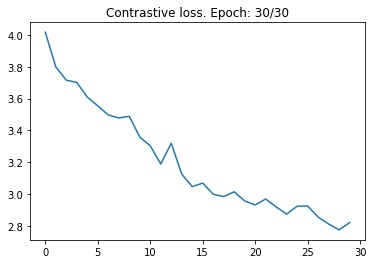

In [ ]:
loss_vals = []
n_epochs = 30
for i in range(n_epochs):
    loss_epoch = []
    for batch, aug_batch1, aug_batch2, label in loader:
        loss_item = train(encoder, aug_batch1, aug_batch2, opt)
        loss_epoch.append(loss_item)
    loss_vals.append(sum(loss_epoch)/len(loss_epoch))
    plt.plot(loss_vals)
    plt.title('Contrastive loss. Epoch: {}/{}'.format(i+1, n_epochs))
    plt.show();
    clear_output(wait=True)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


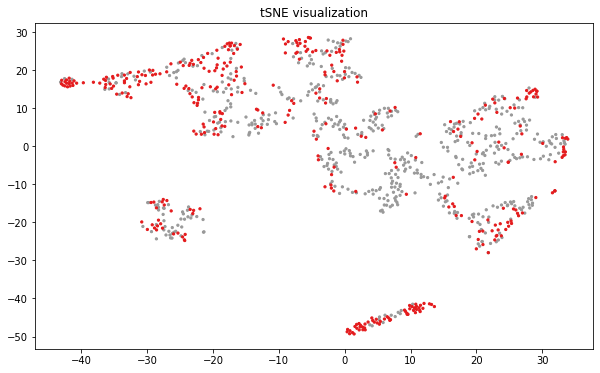

Accuracy: 0.6981


In [ ]:
score = classification_score(graph_train, graph_test, y_train, y_test, encoder)
assert score > 0.65

As we see, we can noticeably improve classification score using self-supervised learning.

### Task 7. Augmentation comparison (1 point)

Here we aim to compare augmentation techniques and conclude which pair is better for PROTEINS dataset.

Write a function `run` that takes a filename with proteins, number of epochs and a list of types of augmentation. It returns a np.array with a classification score matrix where rows are first augmentation, columns are second augmentation. Since the matrix is asymptotically symmetric, calculate the upper triangle values only.

It can take time. To speed up the evaluation, return calculated score matrix without actual training:
```
def run(filename, n_epochs, augs):
    scores = [[0.5, 0.5, 0.5, 0.5, 0.5], [0, 0.5, 0.5, 0.5], ...
    return scores

    ### ACTUAL TRAINING
```

In [ ]:
WITHOUT_TRAINING = True
RATIOS = {
    'drop_nodes' : 0.1, 
    'pert_edges' : 0.2,
    'attr_mask'  : 0.4,
    'rw_subgraph': 0.7,
    'identical'  : 0.0
}

def run(filename, n_epochs, augs):
    # YOUR CODE HERE
    if WITHOUT_TRAINING:
        scores = np.array([
            [0.66037736, 0.66037736, 0.69811321, 0.68867925, 0.67924528],
            [0, 0.6509434 , 0.68867925, 0.68867925, 0.62264151],
            [0, 0, 0.62264151, 0.62264151, 0.67924528],
            [0, 0, 0, 0.6509434 , 0.68867925],
            [0, 0, 0, 0, 0.64150943]
        ])
    else:
        number_augs = len(augs)
        scores = np.empty((number_augs, number_augs))
        for i in range(number_augs):
            for j in range(i, number_augs):
                augmentations = []
                augmentations.append(GraphAugmentation(augs[i], ratio=RATIOS[augs[i]]))
                augmentations.append(GraphAugmentation(augs[j], ratio=RATIOS[augs[j]]))
                dataset = ContrastiveDataset(filename=filename, augmentations=augmentations)

                c_dataset = connected_subset(dataset)

                loader = GraphDataLoader(
                    c_dataset,
                    batch_size=64,
                    drop_last=False,
                    shuffle=True)
                
                encoder = GCNEncoder(input_dim=3, hidden_dim=32, output_dim=16)
                encoder.to(device)
                opt = Adam(encoder.parameters(), lr=0.005)

                loss_vals = []
                for epoch in range(n_epochs):
                    loss_epoch = []
                    for batch, aug_batch1, aug_batch2, label in loader:
                        loss_item = train(encoder, aug_batch1, aug_batch2, opt)
                        loss_epoch.append(loss_item)
                    loss_vals.append(sum(loss_epoch)/len(loss_epoch))
                    plt.plot(loss_vals)
                    plt.title(f'Contrastive loss. Augs: {augs[i]}, {augs[j]}. Epoch: {epoch+1}/{n_epochs}')
                    plt.show();
                    clear_output(wait=True)

                score = classification_score(graph_train, graph_test, y_train, y_test, encoder)
                scores[i][j] = score
        
    return scores

In [ ]:
augs = ['drop_nodes', 'pert_edges', 'attr_mask', 'rw_subgraph', 'identical']
res = run('proteins.bin', n_epochs=30, augs=augs)
symm = (res.T + res - np.diag(res[range(5), range(5)])).sum(0)
assert np.all((res > 0).sum(0) == np.arange(5) + 1)
assert np.all(res[res > 0] > 0.6)
assert symm[0] > symm[4]
assert symm[2] > symm[4]

In [ ]:
pd.DataFrame(res, index=augs, columns=augs).round(4)

,drop_nodes,pert_edges,attr_mask,rw_subgraph,identical
drop_nodes,0.6604,0.6604,0.6981,0.6887,0.6792
pert_edges,0.0000,0.6509,0.6887,0.6887,0.6226
attr_mask,0.0000,0.0000,0.6226,0.6226,0.6792
rw_subgraph,0.0000,0.0000,0.0000,0.6509,0.6887
identical,0.0000,0.0000,0.0000,0.0000,0.6415
